In [1]:
!ls /media/erogol/data_ssd/Models/libri_tts/speaker_encoder/libritts_360-September-03-2019_03+53PM-dc69074/

checkpoint_10000.pth.tar  config.json
checkpoint_20000.pth.tar  events.out.tfevents.1567518806.erogol-desktop
checkpoint_30000.pth.tar


In [1]:
import torch
import os
import umap
import random
import glob
import numpy as np

from TTS.speaker_encoder.model import SpeakerEncoder
from TTS.utils.audio import AudioProcessor
from TTS.utils.generic_utils import load_config

MODEL_PATH = "/media/erogol/data_ssd/Models/libri_tts/speaker_encoder/libritts_360-half-September-28-2019_10+46AM-8565c50/best_model.pth.tar"
CONFIG_PATH = "/media/erogol/data_ssd/Models/libri_tts/speaker_encoder/libritts_360-September-03-2019_03+53PM-dc69074/config.json"
EMBED_PATH = "/home/erogol/Data/Libri-TTS/train-clean-360-embed_128/"
CONFIG = load_config(CONFIG_PATH)
ap = AudioProcessor(**CONFIG['audio'])

 > Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:40
 | > min_level_db:-100
 | > frame_shift_ms:12.5
 | > frame_length_ms:50
 | > ref_level_db:20
 | > num_freq:1025
 | > power:None
 | > preemphasis:0.98
 | > griffin_lim_iters:None
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > n_fft:2048
 | > hop_length:200
 | > win_length:800


In [2]:
embed_files = glob.glob(EMBED_PATH+"/**/*.npy", recursive=True)
print(len(embed_files))

116500


In [3]:
embed_files[0]

'/home/erogol/Data/Libri-TTS/train-clean-360-embed_128/1025/75365/1025_75365_000002_000002.npy'

In [4]:
speaker_paths = list(set([os.path.dirname(os.path.dirname(embed_file)) for embed_file in embed_files]))
speaker_to_utter = {}
for embed_file in embed_files:
    speaker_path = os.path.dirname(os.path.dirname(embed_file))
    try:
        speaker_to_utter[speaker_path].append(embed_file)
    except:
        speaker_to_utter[speaker_path]=[embed_file]
print(len(speaker_paths))

904


In [5]:
embeds = []
labels = []
num_speakers = 20
num_utters = 10
speaker_idxs = np.random.choice(range(len(speaker_paths)), num_speakers, replace=False )

for speaker_num, speaker_idx in enumerate(speaker_idxs):
    speaker_path = speaker_paths[speaker_idx]
    speakers_utter = speaker_to_utter[speaker_path]
    utter_idxs = np.random.randint(0, len(speakers_utter) , num_utters)
    for utter_idx in utter_idxs:
            embed_path = speaker_to_utter[speaker_path][utter_idx]
            embed = np.load(embed_path)
            embeds.append(embed)
            labels.append(speaker_num)
embeds = np.concatenate(embeds)

In [6]:
from matplotlib import cm
viridis = cm.get_cmap('tab20', num_speakers)

/home/erogol/miniconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/erogol/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


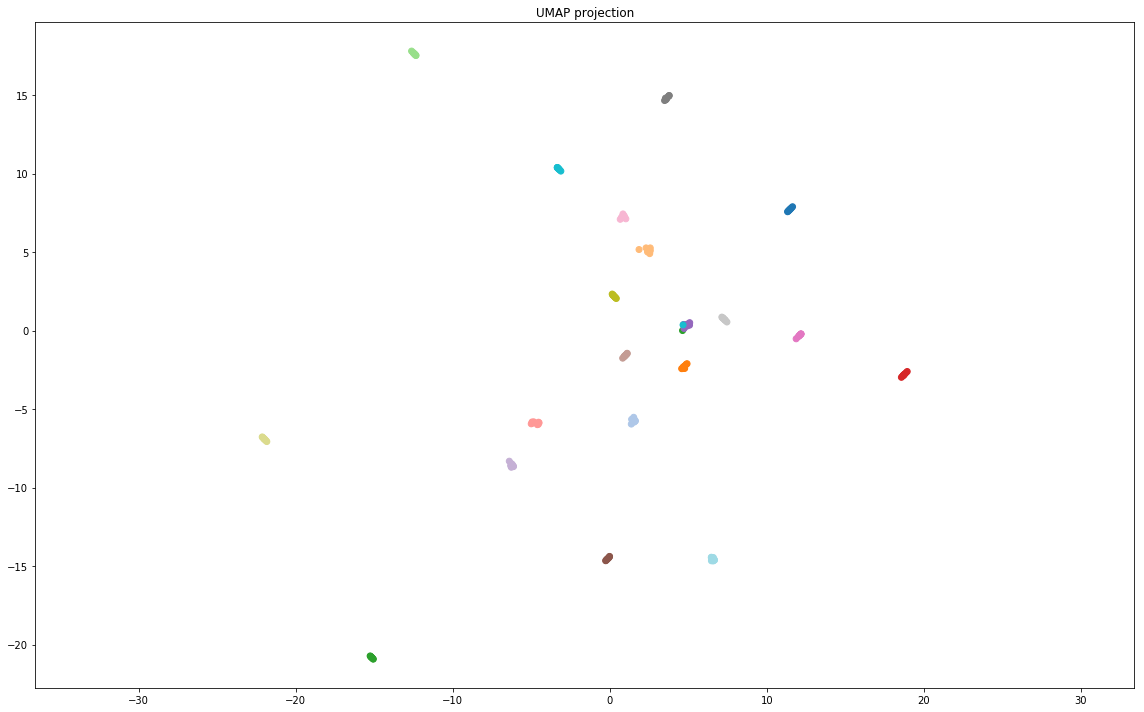

In [7]:
from matplotlib import pylab as plt
%matplotlib inline

model = umap.UMAP()
projection = model.fit_transform(embeds)
colors = [viridis(i) for i in labels]

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.scatter(projection[:, 0], projection[:, 1], c=colors)
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection")
plt.tight_layout()